# Text Analysis with (MBTI) Myers-Briggs Personality Type Dataset

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# read data
data = pd.read_csv('mbti_1.csv') # dtype = {'type': str,'post': ,

## Overview of the data

In [7]:
data.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [8]:
### One post

In [9]:
data.head(1).posts.values

array([ "'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design

# Distribution of the target variable?

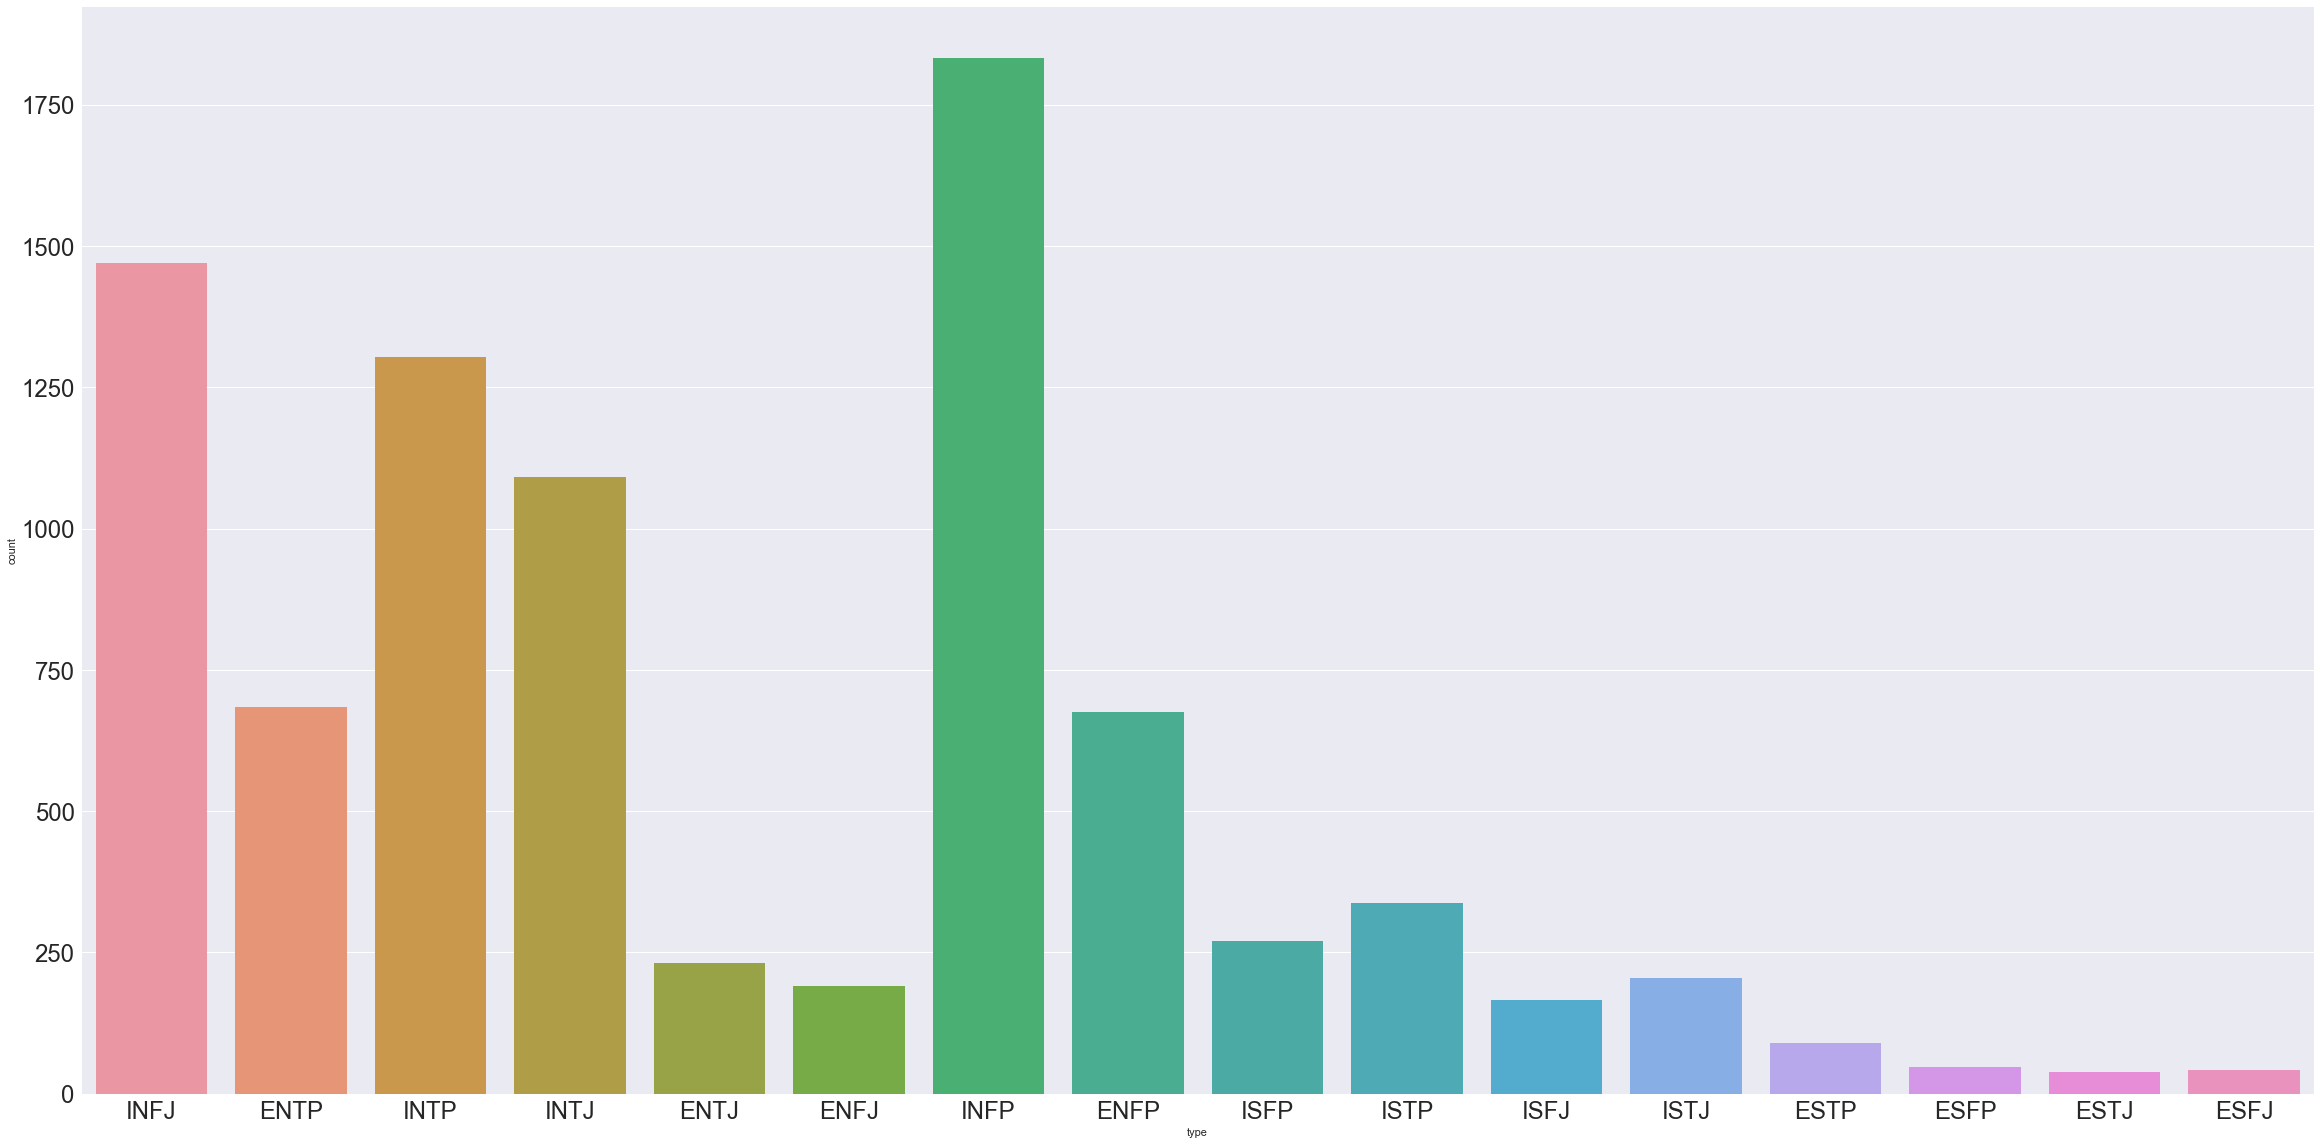

In [10]:
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

### It is clearly unbalanced throughout the different classes. 

# Preprocessing

In [11]:
##### Encode each type to an int

from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)


In [19]:
##### Compute list of subject with Type | list of comments | list of url

list_subject = []

for row in data.iterrows():
    list_comment = []
    list_url = []
    posts = row[1].posts
    for post in posts.split("|||"):
        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', post)
        if urls:
            post = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', post)
            list_url += urls
        if any(post):
            list_comment.append(post)
    
    type_labelized = lab_encoder.transform([row[1].type])[0]
    list_subject.append([type_labelized, list_comment, list_url])

del data
subject_type = np.array([subject[0] for subject in list_subject])
#subject_comments = ["".join(subject[1]) for subject in list_subject]

NameError: name 'data' is not defined

#### Exemple of one row

In [13]:
list_subject[0]

[8,
 ["'",
  'enfp and intj moments    sportscenter not top ten plays    pranks',
  'What has been the most life-changing experience in your life?',
  '     On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   ',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390     ...',
  'Welcome and stuff.',
  '  Game. Set. Match.',
  "Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...",
  "Basically come up with three items you've determined that each type (or whichever types you want to do) would more than likely use, given each types' cognitive fun

In [14]:
##### Remove and clean comments

from nltk import word_tokenize
#X = [word_tokenize("".join(subject[1])) for subject in list_subject]

# Remove numbers
subject_comments_1 = [re.sub("[^a-zA-Z]", " ", " ".join(sentence[1])).split(' ') for sentence in list_subject]

# Remove spaces
subject_comments_1 = [re.sub(' +', ' ', " ".join(comments)) for comments in subject_comments_1]

In [15]:
# Remove stopwords

from nltk.corpus import stopwords 

# subject_comments_1 = [" ".join([w for w in comment.split(' ') if w not in stopwords.words("english")]) for comment in subject_comments_1]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, analyzer='word', max_features=100,
                             min_df=3,
                             use_idf=True)
X_tfidf =  vectorizer.fit_transform(subject_comments_1).todense()
pickle.dump(vectorizer, open("tfidf.pickle.dat", "wb"))

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1500) 

X_vectorized = vectorizer.fit_transform(subject_comments_1).toarray()

pickle.dump(vectorizer, open("CountVect.pickle.dat", "wb"))

X_concat = np.column_stack((X_tfidf, X_vectorized))

In [21]:
# Confusion plot
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
##### Multinomial Naive Bayes

from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

def train_stratified(model, X, y, nsplits=3):
    '''
    Take a sklearn model like, feature set X, target set y and number of splits to compute Stratified kfold validation.
    '''
    for train, test in StratifiedKFold(subject_type, shuffle=True):
        model.fit(X[train], y[train])
        preds = model.predict(X[test])
        print(classification_report(y[test], preds))
            
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y[test], preds)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                              title='Normalized confusion matrix')

             precision    recall  f1-score   support

          0       0.38      0.41      0.39        64
          1       0.48      0.52      0.49       225
          2       0.39      0.55      0.45        77
          3       0.60      0.53      0.56       229
          4       0.05      0.14      0.08        14
          5       0.12      0.06      0.08        16
          6       0.10      0.08      0.09        13
          7       0.12      0.17      0.14        30
          8       0.76      0.49      0.60       490
          9       0.57      0.67      0.61       611
         10       0.62      0.58      0.60       364
         11       0.61      0.59      0.60       435
         12       0.57      0.30      0.40        56
         13       0.29      0.37      0.32        91
         14       0.51      0.54      0.52        69
         15       0.38      0.52      0.44       113

avg / total       0.57      0.54      0.55      2897

Normalized confusion matrix
             pr

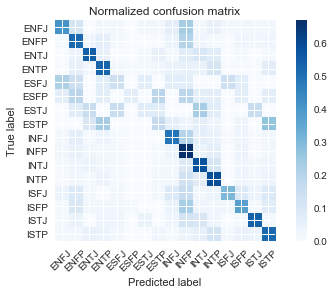

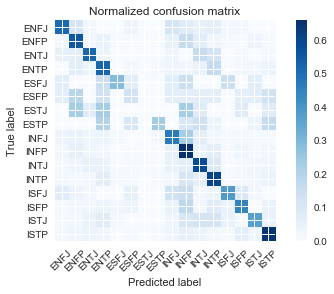

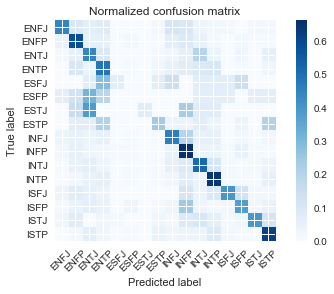

In [29]:
train_stratified(MultinomialNB(), X_concat, subject_type, 5)

[0]	train-merror:0.386639	test-merror:0.41077
[1]	train-merror:0.361371	test-merror:0.391094
[2]	train-merror:0.349429	test-merror:0.379013
[3]	train-merror:0.339045	test-merror:0.372109
[4]	train-merror:0.325891	test-merror:0.362444
[5]	train-merror:0.317411	test-merror:0.357956
[6]	train-merror:0.312219	test-merror:0.357266
[7]	train-merror:0.302354	test-merror:0.35554
[8]	train-merror:0.295777	test-merror:0.351053
[9]	train-merror:0.29145	test-merror:0.351743
[10]	train-merror:0.284528	test-merror:0.351398
[11]	train-merror:0.279162	test-merror:0.350362
[12]	train-merror:0.269124	test-merror:0.344149
[13]	train-merror:0.263932	test-merror:0.343114
[14]	train-merror:0.25874	test-merror:0.341042
             precision    recall  f1-score   support

          0       0.52      0.41      0.46        64
          1       0.68      0.62      0.65       225
          2       0.61      0.36      0.46        77
          3       0.64      0.65      0.65       229
          4       0.50      

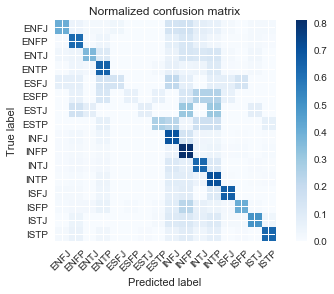

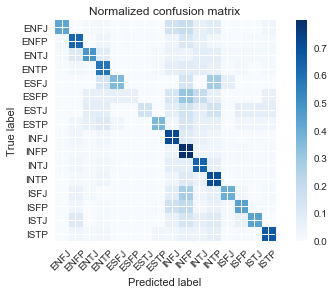

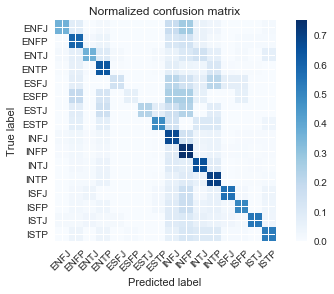

In [31]:
##### Extreme Gradient Boosting

import xgboost as xgb

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.6
param['ntrees'] = 300
param['subsample'] = 0.93
param['max_depth'] = 2
param['silent'] = 1
param['nthread'] = 8
param['num_class'] = len(unique_type_list)

def train_stratified_xgb(X, y, nsplits):
    '''
    Stratified kfold validation for xgboost.
    '''
    for train, test in StratifiedKFold(subject_type, nsplits):
        train_X, train_Y, test_X, test_Y = X[train], y[train], X[test], y[test]
        xg_train = xgb.DMatrix(train_X, label=train_Y)
        xg_test = xgb.DMatrix(test_X, label=test_Y)
        watchlist = [(xg_train, 'train'), (xg_test, 'test')]
        num_round = 15
        bst = xgb.train(param, xg_train, num_round, watchlist)
        preds = bst.predict(xg_test)
        print(classification_report(y[test], preds))
        # get prediction
        error_rate = np.sum(preds != test_Y) / test_Y.shape[0]
        print('Test error using softmax = {}'.format(error_rate))
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(test_Y, preds)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                              title='Normalized confusion matrix')

train_stratified_xgb(X_concat, subject_type, 3)

In [40]:
# Save model for later use
from sklearn.model_selection import train_test_split
import pickle

X, y, nsplits = X_concat, subject_type, 1
train_X, test_X, train_Y, test_Y = train_test_split(X_concat, y,
                                                    stratify=y, 
                                                    test_size=0.25)
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 15
bst = xgb.train(param, xg_train, num_round, watchlist)
preds = bst.predict(xg_test)
print(classification_report(test_Y, preds))
# get prediction
error_rate = np.sum(preds != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))
        
# save model to file
pickle.dump(bst, open("model.pickle.dat", "wb"))

[0]	train-merror:0.395327	test-merror:0.395574
[1]	train-merror:0.369198	test-merror:0.374827
[2]	train-merror:0.354442	test-merror:0.357308
[3]	train-merror:0.339686	test-merror:0.349931
[4]	train-merror:0.325546	test-merror:0.34947
[5]	train-merror:0.321396	test-merror:0.343937
[6]	train-merror:0.312942	test-merror:0.344859
[7]	train-merror:0.304334	test-merror:0.343937
[8]	train-merror:0.298647	test-merror:0.341171
[9]	train-merror:0.290655	test-merror:0.339327
[10]	train-merror:0.285736	test-merror:0.342093
[11]	train-merror:0.277744	test-merror:0.342093
[12]	train-merror:0.273286	test-merror:0.341632
[13]	train-merror:0.26806	test-merror:0.344398
[14]	train-merror:0.261144	test-merror:0.343476
             precision    recall  f1-score   support

          0       0.62      0.42      0.50        48
          1       0.62      0.60      0.61       169
          2       0.65      0.48      0.55        58
          3       0.66      0.67      0.66       171
          4       0.50    

/Users/Dupi/venv_py_3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1134: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
import pandas as pd
import numpy as np
import pickle
import re
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load data

data = pd.read_csv('mbti_1.csv') # dtype = {'type': str,'post': ,

##### Encode each type to an int

from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)


##### Compute list of subject with Type | list of comments | list of url

print("Preprocessing data")
list_subject = []

for row in data.iterrows():
    list_comment = []
    list_url = []
    posts = row[1].posts
    for post in posts.split("|||"):
        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', post)
        if urls:
            post = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', post)
            list_url += urls
        if any(post):
            list_comment.append(post)
    
    type_labelized = lab_encoder.transform([row[1].type])[0]
    list_subject.append([type_labelized, list_comment, list_url])

del data
subject_type = np.array([subject[0] for subject in list_subject])
subject_comments = ["".join(subject[1]) for subject in list_subject]

##### Remove and clean comments

from nltk import word_tokenize
#X = [word_tokenize("".join(subject[1])) for subject in list_subject]

# Remove numbers
subject_comments_1 = [re.sub("[^a-zA-Z]", " ", " ".join(sentence[1])).split(' ') for sentence in list_subject]

# Remove spaces
subject_comments_1 = [re.sub(' +', ' ', " ".join(comments)) for comments in subject_comments_1]


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

print("Tf-idf vectorization")
tfVec = pickle.load(open("tfidf.pickle.dat", "rb"))
X_tfidf = tfVec.transform(subject_comments_1).todense()

print("Bag of words vectorization")
CountVect = pickle.load(open("CountVect.pickle.dat", "rb"))
X_vectorized = CountVect.transform(subject_comments_1).toarray()


# load model from file
loaded_model = pickle.load(open("model.pickle.dat", "rb"))

X_concat = np.column_stack((X_tfidf, X_vectorized))


Preprocessing data
Tf-idf vectorization
Bag of words vectorization


In [42]:
X_concat

matrix([[ 0.14,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  1.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        ..., 
        [ 0.  ,  0.  ,  0.  , ...,  1.  ,  0.  ,  1.  ],
        [ 0.15,  0.07,  0.21, ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.26,  0.  , ...,  2.  ,  0.  ,  0.  ]])

             precision    recall  f1-score   support

          0       0.79      0.58      0.67       190
          1       0.71      0.67      0.69       675
          2       0.73      0.55      0.63       231
          3       0.71      0.68      0.69       685
          4       0.92      0.55      0.69        42
          5       0.88      0.46      0.60        48
          6       1.00      0.51      0.68        39
          7       0.79      0.60      0.68        89
          8       0.70      0.74      0.72      1470
          9       0.71      0.81      0.76      1832
         10       0.71      0.69      0.70      1091
         11       0.70      0.77      0.74      1304
         12       0.79      0.61      0.69       166
         13       0.73      0.57      0.64       271
         14       0.77      0.64      0.70       205
         15       0.80      0.69      0.74       337

avg / total       0.72      0.72      0.72      8675

Test error using softmax = 0.28172910662824

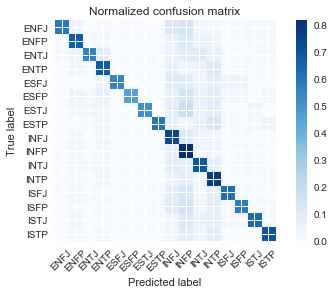

In [43]:
# Confusion plot
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
import xgboost as xgb

xg_test = xgb.DMatrix(X_concat, subject_type)

# make predictions for test data
preds = loaded_model.predict(xg_test)
print(classification_report(subject_type, preds))

# get prediction
error_rate = np.sum(preds != subject_type) / subject_type.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# Compute confusion matrix
cnf_matrix = confusion_matrix(subject_type, preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                      title='Normalized confusion matrix')

## 